Prototype d'environnement et execution avec 40000 échantillons, 80% pour l'entrainement (dont 15% de validation) et 20% pour les tests.


In [1]:
from rakuten_common import *

NB_ECHANTILLONS = 40000


In [3]:
spacynlp = None
french_stop_words = set(stopwords.words('french'))
def tokenize_spacy(sentence):
    """
    Tokenizer basé sur spacy
    """
    global spacynlp
    if spacynlp is None:
        spacynlp = spacy.load("fr_core_news_sm")
        spacynlp.disable_pipes ('tagger', 'parser', 'ner')
    s = sentence
    t = [x.lemma_ for x in spacynlp(s)]
    #t = [x.text for x in spacynlp(s) if not x.text in french_stop_words]
    return t

class TextOneHot(RakutenBaseModel):
    """
    Modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn <TfidfVectorizer | SelectFromModel(LinearSVC)>
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.maxfeatures = 80000 # Nombre de features selectionnées par SVC
                
        self.select = make_pipeline(
            TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # mieux mais long!
                  #lowercase=True,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(inp)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train_select = get_y()[off_start:off_end]
        X_train = get_X_text(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train_select).toarray()
        self.input_shape = X_train.shape[1:]
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test).toarray()
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()

        return self.compile_and_train_gen(X_train, y_train, X_val, y_val,
                                          optimizer='rmsprop',
                                          epochs=50, patience_stop=7, patience_lr=4,
                                          class_weight=[])
        

++ [07h33mn] TextOneHot: Evaluation avec 40000 échantillons
++ [07h33mn] TextOneHot: fit(): Début
Epoch 1/50
850/850 [==============================] - 88s 101ms/step - loss: 1.7357 - accuracy: 0.5622 - val_loss: 0.7389 - val_accuracy: 0.7950
Epoch 2/50
850/850 [==============================] - 65s 77ms/step - loss: 0.5868 - accuracy: 0.8447 - val_loss: 0.6908 - val_accuracy: 0.8092
Epoch 3/50
850/850 [==============================] - 64s 75ms/step - loss: 0.3863 - accuracy: 0.8978 - val_loss: 0.7139 - val_accuracy: 0.8087
Epoch 4/50
850/850 [==============================] - 65s 76ms/step - loss: 0.2891 - accuracy: 0.9240 - val_loss: 0.7423 - val_accuracy: 0.8121
Epoch 5/50
850/850 [==============================] - 64s 76ms/step - loss: 0.2516 - accuracy: 0.9330 - val_loss: 0.7837 - val_accuracy: 0.8129
Epoch 6/50
850/850 [==============================] - 64s 75ms/step - loss: 0.2049 - accuracy: 0.9477 - val_loss: 0.8206 - val_accuracy: 0.8131

Epoch 00006: ReduceLROnPlateau reduc

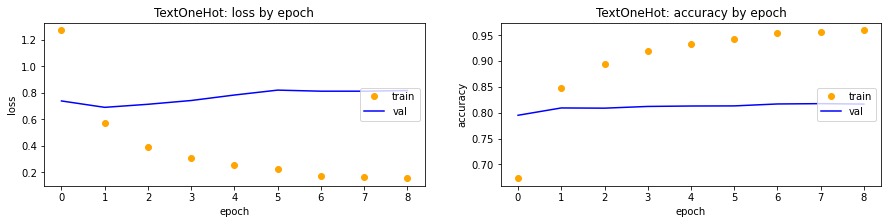

++ [07h44mn] TextOneHot: fit(): Fin

++ [07h44mn] TextOneHot: predict(): Début
250/250 [==============================] - 2s 8ms/step
++ [07h44mn] TextOneHot: predict(): Fin

++ [07h44mn] TextOneHot: w-f1-score = 0.8073

              precision    recall  f1-score   support

          10       0.41      0.71      0.52       304
        1140       0.76      0.74      0.75       252
        1160       0.94      0.90      0.92       383
        1180       0.91      0.41      0.57        73
        1280       0.71      0.72      0.72       461
        1281       0.67      0.58      0.62       218
        1300       0.93      0.92      0.93       488
        1301       0.95      0.86      0.90        63
        1302       0.83      0.77      0.80       224
        1320       0.85      0.76      0.80       322
        1560       0.80      0.85      0.82       495
        1920       0.86      0.86      0.86       403
        1940       0.94      0.82      0.88        78
        2060       0.7

In [4]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [4]:
class Multilingu(RakutenBaseModel):
    """
    Modèle de plongement (embedding) dans un modèle de texte préentrainé
    (Multilingual-large)
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.embedding_length = 512 # Défini par le modèle Multilingual/large
        self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(200, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3, class_weight=[])
        


++ [07h44mn] Multilingu: Evaluation avec 40000 échantillons
++ [07h44mn] Multilingu: fit(): Début
Epoch 1/50
850/850 [==============================] - 3s 2ms/step - loss: 1.7807 - accuracy: 0.5182 - val_loss: 0.8225 - val_accuracy: 0.7471
Epoch 2/50
850/850 [==============================] - 1s 1ms/step - loss: 0.9159 - accuracy: 0.7219 - val_loss: 0.7657 - val_accuracy: 0.7648
Epoch 3/50
850/850 [==============================] - 1s 1ms/step - loss: 0.8258 - accuracy: 0.7430 - val_loss: 0.7379 - val_accuracy: 0.7738
Epoch 4/50
850/850 [==============================] - 1s 1ms/step - loss: 0.7574 - accuracy: 0.7613 - val_loss: 0.7318 - val_accuracy: 0.7754
Epoch 5/50
850/850 [==============================] - 1s 1ms/step - loss: 0.7005 - accuracy: 0.7765 - val_loss: 0.7287 - val_accuracy: 0.7710
Epoch 6/50
850/850 [==============================] - 1s 1ms/step - loss: 0.6787 - accuracy: 0.7781 - val_loss: 0.7183 - val_accuracy: 0.7846- accuracy
Epoch 7/50
850/850 [====================

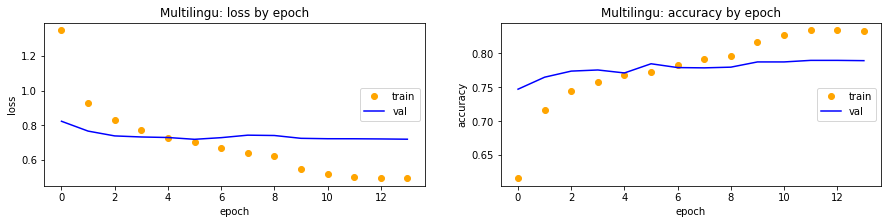

++ [07h45mn] Multilingu: fit(): Fin

++ [07h45mn] Multilingu: predict(): Début
250/250 [==============================] - 0s 687us/step
++ [07h45mn] Multilingu: predict(): Fin

++ [07h45mn] Multilingu: w-f1-score = 0.7763

              precision    recall  f1-score   support

          10       0.57      0.62      0.59       304
        1140       0.74      0.75      0.74       252
        1160       0.87      0.91      0.89       383
        1180       0.67      0.45      0.54        73
        1280       0.58      0.57      0.58       461
        1281       0.68      0.49      0.57       218
        1300       0.78      0.89      0.83       488
        1301       0.87      0.83      0.85        63
        1302       0.78      0.67      0.72       224
        1320       0.76      0.67      0.72       322
        1560       0.78      0.74      0.76       495
        1920       0.84      0.88      0.86       403
        1940       0.82      0.85      0.84        78
        2060       0

In [6]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [5]:
class EffNet(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle qui attend des données [..255]
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 10
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen
    
    def compile_and_train(self, traingen, valgen, optimizer, patience, epochs):
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min')]
        self.model.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen, epochs=epochs,
                                      steps_per_epoch = traingen.n//traingen.batch_size,
                                      validation_data = valgen,
                                      validation_steps = valgen.n//valgen.batch_size,
                                      callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         patience=1,
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   patience=2,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file="X_train_update.csv"):
        """ Prédiction, en utilisant le générateur de données de test """
        length = off_end - off_start
        self.prt(f"Prédiction de {length} échantillons")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        testgen = self.__get_test_dataset(X_imgpaths)
        
        softmaxout = self.model.predict(testgen, verbose = 1)
        assert len(self.fit_labels) == NB_CLASSES
        y_pred = [self.fit_labels[i] for i in np.argmax(softmaxout, axis=1)]
        self.prt("Prédiction terminée")
        return y_pred


++ [23h06mn] EffNet: Evaluation avec 40000 échantillons
++ [23h06mn] EffNet: Création des générateurs d'images
Found 27200 validated image filenames belonging to 27 classes.
Found 4800 validated image filenames belonging to 27 classes.
++ [23h06mn] EffNet: Congélation des layers du modèle de base et entrainement
Epoch 1/10
850/850 [==============================] - 1990s 2s/step - loss: 2.2627 - accuracy: 0.3961 - val_loss: 1.5694 - val_accuracy: 0.5402
Epoch 2/10
850/850 [==============================] - 1950s 2s/step - loss: 1.5860 - accuracy: 0.5290 - val_loss: 1.5066 - val_accuracy: 0.5606
Epoch 3/10
850/850 [==============================] - 1958s 2s/step - loss: 1.4749 - accuracy: 0.5517 - val_loss: 1.5063 - val_accuracy: 0.5531
Epoch 4/10
850/850 [==============================] - 1950s 2s/step - loss: 1.3867 - accuracy: 0.5752 - val_loss: 1.4373 - val_accuracy: 0.5788
Epoch 5/10
850/850 [==============================] - 1950s 2s/step - loss: 1.3219 - accuracy: 0.5903 - val_lo

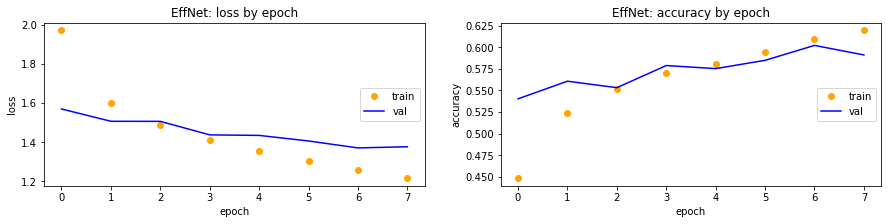

++ [03h27mn] EffNet: Décongélation des 8 derniers layers et entrainement
Epoch 1/10
850/850 [==============================] - 2017s 2s/step - loss: 1.1006 - accuracy: 0.6545 - val_loss: 1.3171 - val_accuracy: 0.6112
Epoch 2/10
850/850 [==============================] - 12339s 15s/step - loss: 0.9916 - accuracy: 0.6868 - val_loss: 1.3005 - val_accuracy: 0.6202
Epoch 3/10
850/850 [==============================] - 2008s 2s/step - loss: 0.9236 - accuracy: 0.7064 - val_loss: 1.3096 - val_accuracy: 0.6212
Epoch 4/10
850/850 [==============================] - 2102s 2s/step - loss: 0.8631 - accuracy: 0.7216 - val_loss: 1.3095 - val_accuracy: 0.6285
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


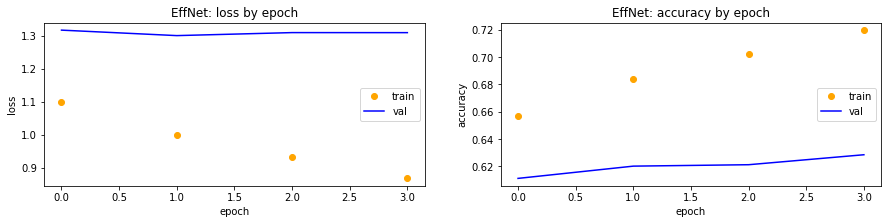

++ [08h35mn] EffNet: Entrainement terminé
++ [08h35mn] EffNet: Prédiction de 8000 échantillons
Found 8000 validated image filenames.
8000/8000 [==============================] - 482s 60ms/step
++ [08h43mn] EffNet: Prédiction terminée
++ [08h43mn] EffNet: w-f1-score = 0.6164

              precision    recall  f1-score   support

          10       0.51      0.63      0.56       304
        1140       0.59      0.60      0.60       252
        1160       0.88      0.93      0.90       383
        1180       0.53      0.32      0.40        73
        1280       0.41      0.39      0.40       461
        1281       0.41      0.22      0.29       218
        1300       0.65      0.74      0.69       488
        1301       0.67      0.51      0.58        63
        1302       0.49      0.38      0.43       224
        1320       0.52      0.43      0.47       322
        1560       0.58      0.64      0.61       495
        1920       0.73      0.81      0.77       403
        1940       0.

In [6]:
EffNet().evaluate(NB_ECHANTILLONS)

++ [09h17mn] CatModel: Evaluation avec 40000 échantillons
++ [09h17mn] CatModel: Chargements des modèles référencés "40000"
Chargement de l'objet (modele_rakuten_out\TextOneHot_40000_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_40000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_40000_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_40000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNet_40000_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNet_40000_model.hdf5)
++ [09h17mn] CatModel: Preprocessing des 32000 données d'entrainement
++ [09h17mn] CatModel: Instantiation des générateurs d'entrainement
Nettoyage de modele_rakuten_out\CatDataset_train_27200


  1%|▍                                                                                 | 5/850 [00:00<00:19, 44.00it/s]

Création de 850 fichiers de batch dans modele_rakuten_out\CatDataset_train_27200
* modèle TextOneHot


  6%|████▉                                                                           | 53/850 [00:00<00:01, 527.13it/s]

* modèle Multilingu


  0%|                                                                                          | 0/850 [00:00<?, ?it/s]

* modèle EffNet


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Nettoyage de modele_rakuten_out\CatDataset_val_4800
Création de 150 fichiers de batch dans modele_rakuten_out\CatDataset_val_4800
* modèle TextOneHot


 40%|████████████████████████████████                                                | 60/150 [00:00<00:00, 596.01it/s]

* modèle Multilingu


  1%|▌                                                                                 | 1/150 [00:00<00:26,  5.63it/s]

* modèle EffNet


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.79it/s]


++ [09h21mn] CatModel: Création du modèle
  * Layers non entrainables:
      - input_EffNet
      - efficientnetb1
      - global_average_pooling2d_2
      - dense_1_EffNet
      - input_1_TextOneHot
      - input_1_Multilingu
      - batchnorm_2_EffNet
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dropout_3_EffNet
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - dense_4_EffNet
      - batchnorm_4_TextOneHot
      - dropout_4_Multilingu
      - batchnorm_5_EffNet
      - concatenate_1_CatModel
  * Layers entrainables:
      - dense_2_CatModel
      - dropout_3_CatModel
      - dense_4_CatModel
  * Init des layers avec les poids des modèles de base:
      - dense_2_TextOneHot
      - batchnorm_4_TextOneHot
      - batchnorm_2_Multilingu
      - dense_3_Multilingu
      - efficientnetb1
      - dense_1_EffNet
      - batchnorm_2_EffNet
      - dense_4_EffNet
      - batchnorm_5_EffNet
++ [09h21mn] CatModel: fit(): Début
Epoch 1/12
850/850 [=============

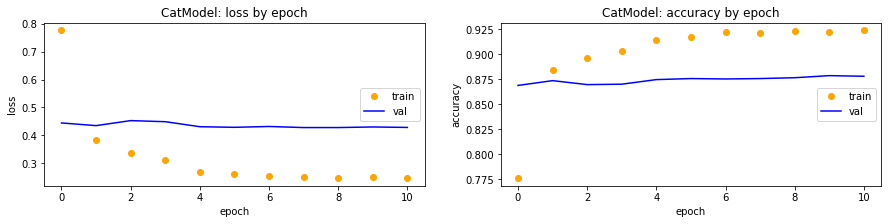

++ [16h48mn] CatModel: Prédiction pour 8000 échantillons
++ [16h48mn] CatModel: Preprocessing des données de test
++ [16h48mn] CatModel: Instantiation du générateur de test
Nettoyage de modele_rakuten_out\CatDataset_test_8000


  1%|▌                                                                              | 55/8000 [00:00<00:14, 540.72it/s]

Création de 8000 fichiers de batch dans modele_rakuten_out\CatDataset_test_8000
* modèle TextOneHot


  1%|▍                                                                              | 50/8000 [00:00<00:16, 496.32it/s]

* modèle Multilingu


  0%|                                                                               | 11/8000 [00:00<01:16, 104.97it/s]

* modèle EffNet


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:56<00:00, 142.01it/s]


++ [16h50mn] CatModel: predict(): Début
8000/8000 [==============================] - 590s 73ms/step
++ [17h00mn] CatModel: predict(): Fin

++ [17h00mn] CatModel: w-f1-score = 0.853

              precision    recall  f1-score   support

          10       0.73      0.71      0.72       304
        1140       0.79      0.82      0.80       252
        1160       0.97      0.99      0.98       383
        1180       0.75      0.59      0.66        73
        1280       0.70      0.72      0.71       461
        1281       0.71      0.57      0.63       218
        1300       0.91      0.97      0.94       488
        1301       0.90      0.89      0.90        63
        1302       0.85      0.76      0.80       224
        1320       0.83      0.82      0.82       322
        1560       0.86      0.83      0.85       495
        1920       0.87      0.90      0.88       403
        1940       0.88      0.90      0.89        78
        2060       0.78      0.78      0.78       481
       

In [8]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.objs = [
             #TextEmbed(self.nb),
             TextOneHot(self.nb),
             Multilingu(self.nb),
             EffNet(self.nb)
        ]

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputlayers, outputlayers = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputlayers.append(inp)
            outputlayers.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        concatname = self.layer_name("concatenate")
        x = concatenate(outputlayers, axis=-1, name = concatname)
        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
        x = Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputlayers, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers[:-3]:
            layer.trainable = False
            print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-3),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=12,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)
        return history
                                  
CatModel().evaluate(NB_ECHANTILLONS)